<a href="https://colab.research.google.com/github/DashShantanu/network-intrusion-detection-system/blob/main/NIDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
import warnings
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree  import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import BernoulliNB
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFE
import itertools
from xgboost import XGBClassifier
from tabulate import tabulate
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, LeakyReLU
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.layers import BatchNormalization
from keras.callbacks import ReduceLROnPlateau

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train=pd.read_csv(f"/content/drive/MyDrive/My datasets/kddcup_data_10_percent_corrected.csv")

In [4]:
column_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'target']

# Assign column names to the DataFrame
train.columns = column_names

In [5]:
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [6]:
# Specify the file path where you want to save the CSV file
file_path = f"/content/drive/MyDrive/My datasets/kddcup_data_updated.csv"

# Save the DataFrame to a CSV file
train.to_csv(file_path, index=False)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494020 entries, 0 to 494019
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     494020 non-null  int64  
 1   protocol_type                494020 non-null  object 
 2   service                      494020 non-null  object 
 3   flag                         494020 non-null  object 
 4   src_bytes                    494020 non-null  int64  
 5   dst_bytes                    494020 non-null  int64  
 6   land                         494020 non-null  int64  
 7   wrong_fragment               494020 non-null  int64  
 8   urgent                       494020 non-null  int64  
 9   hot                          494020 non-null  int64  
 10  num_failed_logins            494020 non-null  int64  
 11  logged_in                    494020 non-null  int64  
 12  num_compromised              494020 non-null  int64  
 13 

Creating a dictionary of attack_types

In [8]:
attacks_types = {
    'normal': 'normal',
'back': 'dos',
'buffer_overflow': 'u2r',
'ftp_write': 'r2l',
'guess_passwd': 'r2l',
'imap': 'r2l',
'ipsweep': 'probe',
'land': 'dos',
'loadmodule': 'u2r',
'multihop': 'r2l',
'neptune': 'dos',
'nmap': 'probe',
'perl': 'u2r',
'phf': 'r2l',
'pod': 'dos',
'portsweep': 'probe',
'rootkit': 'u2r',
'satan': 'probe',
'smurf': 'dos',
'spy': 'r2l',
'teardrop': 'dos',
'warezclient': 'r2l',
'warezmaster': 'r2l',
}

In [9]:

# Adding Attack Type column
train['Attack Type'] = train.target.apply(lambda r:attacks_types[r[:-1]])
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target,Attack Type
0,0,tcp,http,SF,239,486,0,0,0,0,...,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.,normal
1,0,tcp,http,SF,235,1337,0,0,0,0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,normal
2,0,tcp,http,SF,219,1337,0,0,0,0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,normal
3,0,tcp,http,SF,217,2032,0,0,0,0,...,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.,normal
4,0,tcp,http,SF,217,2032,0,0,0,0,...,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.,normal


In [10]:
train.shape

(494020, 43)

In [11]:
train['target'].value_counts()

smurf.              280790
neptune.            107201
normal.              97277
back.                 2203
satan.                1589
ipsweep.              1247
portsweep.            1040
warezclient.          1020
teardrop.              979
pod.                   264
nmap.                  231
guess_passwd.           53
buffer_overflow.        30
land.                   21
warezmaster.            20
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
Name: target, dtype: int64

In [13]:
train['Attack Type'].value_counts()

dos       391458
normal     97277
probe       4107
r2l         1126
u2r           52
Name: Attack Type, dtype: int64

In [14]:
train.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

Data Preprocessing

In [ ]:
train.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

CATEGORICAL FEATURES DISTRIBUTION

In [15]:
def bar_graph(feature):
    train[feature].value_counts().plot(kind="bar")

<Axes: xlabel='protocol_type', ylabel='count'>

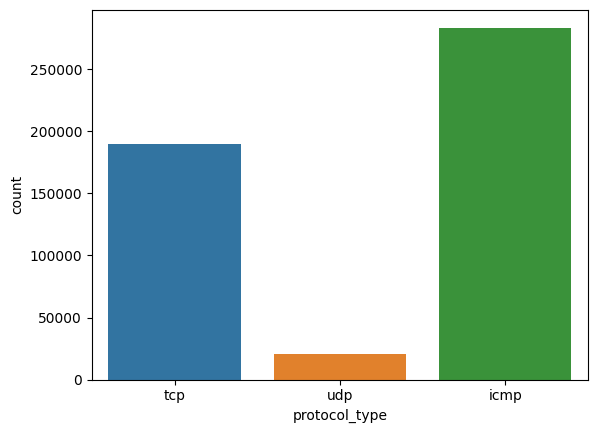

In [31]:
sns.countplot(x=train['protocol_type'])
# We notice that ICMP is the most frequent in the used data, then TCP and only around 20000 packets of UDP type

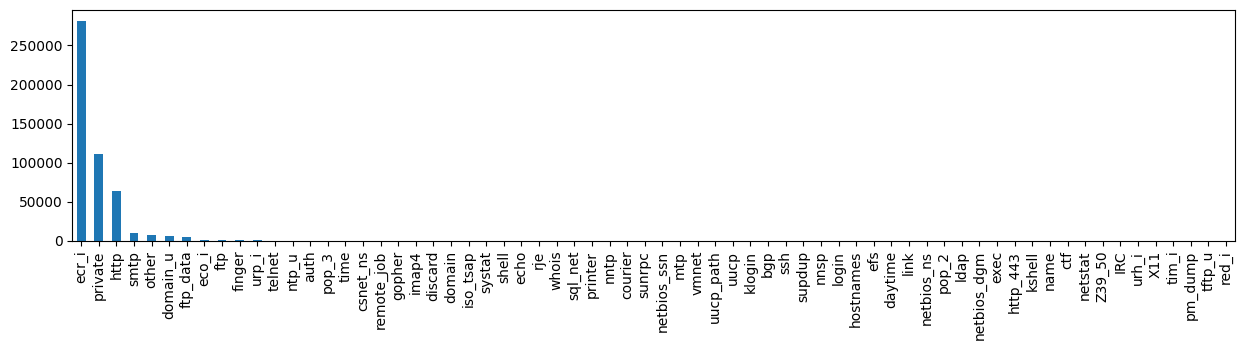

In [30]:
plt.figure(figsize=(15,3))
bar_graph('service')

<Axes: xlabel='flag', ylabel='count'>

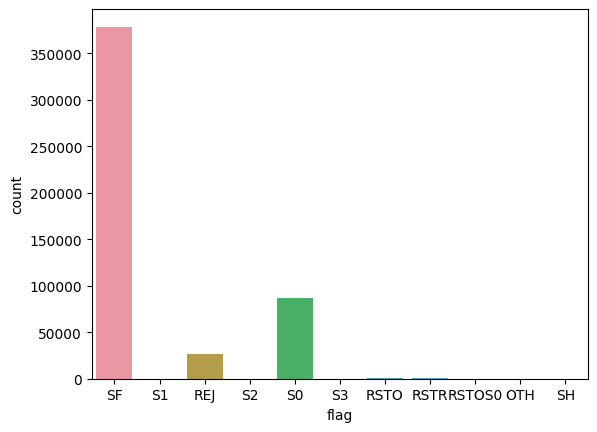

In [25]:
sns.countplot(x=train['flag'])

<Axes: xlabel='logged_in', ylabel='count'>

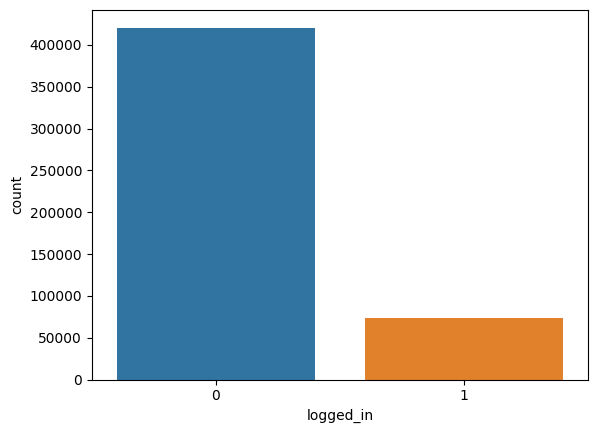

In [22]:
sns.countplot(x=train['logged_in'])
# logged_in (1 if successfully logged in; 0 otherwise): We notice that just around 70000 packets are successfully logged in.

Target Feature Distribution

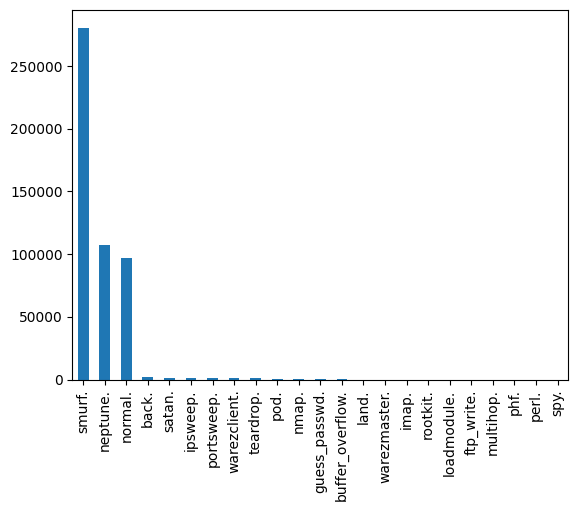

In [37]:
bar_graph('target')

<Axes: xlabel='Attack Type', ylabel='count'>

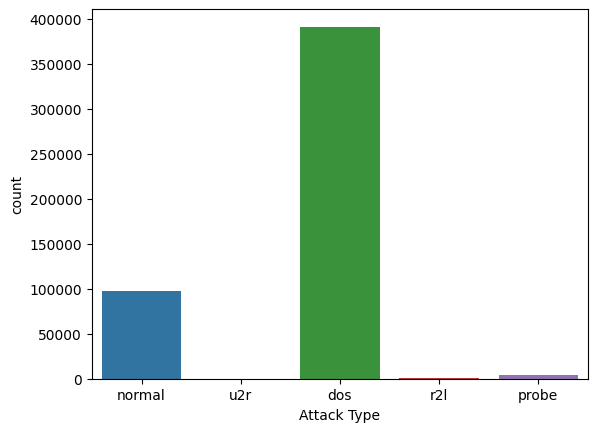

In [38]:
sns.countplot(x=train['Attack Type'])
# The attack types grouped by attack, it's what we will predict

In [ ]:
print('Class distribution Training set:')
print(train['Attack Type'].value_counts())

Class distribution Training set:
dos       391458
normal     97277
probe       4107
r2l         1126
u2r           52
Name: Attack Type, dtype: int64


In [39]:
train.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'target', 'Attack Type'],
      dtype='object')

Data Correlation

<ipython-input-40-075028933ea3>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  train = train.dropna('columns')
<ipython-input-40-075028933ea3>:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train.corr()


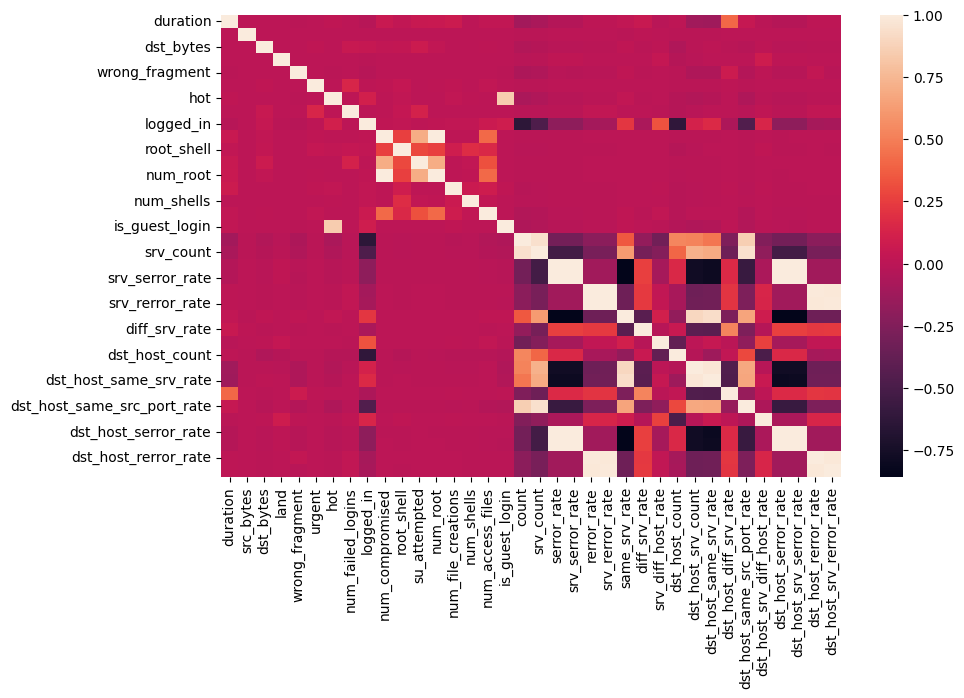

In [40]:
# drop columns with NaN value
train = train.dropna('columns')

# keep columns where there are more than 1 unique values
train = train[[col for col in train if train[col].nunique() > 1]]

corr = train.corr()

plt.figure(figsize =(10, 6))

sns.heatmap(corr)

plt.show()

Calculating Correlations

In [42]:
train['num_root'].corr(train['num_compromised'])

0.9938277978733708

In [43]:
train['srv_serror_rate'].corr(train['serror_rate'])

0.9983615065594137

In [44]:
train['srv_count'].corr(train['count'])

0.9436669953129924

In [45]:
train['srv_rerror_rate'].corr(train['rerror_rate'])

0.9947309533247186

In [46]:
train['dst_host_same_srv_rate'].corr(train['dst_host_srv_count'])

0.9736906960847976

In [47]:
train['dst_host_srv_serror_rate'].corr(train['dst_host_serror_rate'])

0.9981559165358084

In [48]:
train['dst_host_srv_rerror_rate'].corr(train['dst_host_rerror_rate'])

0.9848038351836224

In [49]:
train['dst_host_same_srv_rate'].corr(train['same_srv_rate'])

0.9278079908913963

In [50]:
train['dst_host_srv_count'].corr(train['same_srv_rate'])

0.898959378952988

In [51]:
train['dst_host_same_src_port_rate'].corr(train['srv_count'])

0.9449262532055234

In [52]:
train['dst_host_serror_rate'].corr(train['serror_rate'])

0.9986729674316956

In [53]:
train['dst_host_serror_rate'].corr(train['srv_serror_rate'])

0.9978352994314985

In [54]:
train['dst_host_srv_serror_rate'].corr(train['serror_rate'])

0.9978492476329011

In [55]:
train['dst_host_srv_serror_rate'].corr(train['srv_serror_rate'])

0.9993041088827428

In [56]:
train['dst_host_rerror_rate'].corr(train['rerror_rate'])

0.9869947908670308

In [57]:
train['dst_host_rerror_rate'].corr(train['srv_rerror_rate'])

0.9821663404802362

In [58]:
train['dst_host_srv_rerror_rate'].corr(train['rerror_rate'])

0.9851995522242216

In [59]:
train['dst_host_srv_rerror_rate'].corr(train['srv_rerror_rate'])

0.9865705421991731

In [60]:
# If two values are highly correlated, one of them should be ignored

# This variable is highly correlated with num_compromised
train.drop('num_root', axis = 1, inplace = True)

# This variable is highly correlated with serror_rate
train.drop('srv_serror_rate', axis = 1, inplace = True)

# This variable is highly correlated with rerror_rate
train.drop('srv_rerror_rate', axis = 1, inplace = True)

# This variable is highly correlated with srv_serror_rate
train.drop('dst_host_srv_serror_rate', axis = 1, inplace = True)

# This variable is highly correlated with rerror_rate
train.drop('dst_host_serror_rate', axis = 1, inplace = True)

# This variable is highly correlated with srv_rerror_rate
train.drop('dst_host_rerror_rate', axis = 1, inplace = True)

# This variable is highly correlated with rerror_rate
train.drop('dst_host_srv_rerror_rate', axis = 1, inplace = True)

# This variable is highly correlated with srv_rerror_rate
train.drop('dst_host_same_srv_rate', axis = 1, inplace = True)

In [61]:
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,target,Attack Type
0,0,tcp,http,SF,239,486,0,0,0,0,...,1.0,0.0,0.0,19,19,0.0,0.05,0.0,normal.,normal
1,0,tcp,http,SF,235,1337,0,0,0,0,...,1.0,0.0,0.0,29,29,0.0,0.03,0.0,normal.,normal
2,0,tcp,http,SF,219,1337,0,0,0,0,...,1.0,0.0,0.0,39,39,0.0,0.03,0.0,normal.,normal
3,0,tcp,http,SF,217,2032,0,0,0,0,...,1.0,0.0,0.0,49,49,0.0,0.02,0.0,normal.,normal
4,0,tcp,http,SF,217,2032,0,0,0,0,...,1.0,0.0,0.0,59,59,0.0,0.02,0.0,normal.,normal


In [62]:
train.shape

(494020, 33)

In [63]:
train.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_file_creations', 'num_shells', 'num_access_files',
       'is_guest_login', 'count', 'srv_count', 'serror_rate', 'rerror_rate',
       'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
       'dst_host_count', 'dst_host_srv_count', 'dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'target',
       'Attack Type'],
      dtype='object')

Feature Mapping

In [64]:
train['protocol_type'].value_counts()

icmp    283602
tcp     190064
udp      20354
Name: protocol_type, dtype: int64

In [65]:
train['flag'].value_counts()

SF        378439
S0         87007
REJ        26875
RSTR         903
RSTO         579
SH           107
S1            57
S2            24
RSTOS0        11
S3            10
OTH            8
Name: flag, dtype: int64

In [ ]:
 # protocol_type feature mapping
pmap = {'icmp':0, 'tcp':1, 'udp':2}
train['protocol_type'] = train['protocol_type'].map(pmap)


In [ ]:
 # flag feature mapping
fmap = {'SF':0, 'S0':1, 'REJ':2, 'RSTR':3, 'RSTO':4, 'SH':5, 'S1':6, 'S2':7, 'RSTOS0':8, 'S3':9, 'OTH':10}
train['flag'] = train['flag'].map(fmap)


Remove irrelevant features such as ‘service’ before modelling

In [ ]:
train.drop('service', axis = 1, inplace = True)

In [ ]:
train.head()

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,target,Attack Type
0,0,1,0,239,486,0,0,0,0,0,...,1.0,0.0,0.0,19,19,0.0,0.05,0.0,normal.,normal
1,0,1,0,235,1337,0,0,0,0,0,...,1.0,0.0,0.0,29,29,0.0,0.03,0.0,normal.,normal
2,0,1,0,219,1337,0,0,0,0,0,...,1.0,0.0,0.0,39,39,0.0,0.03,0.0,normal.,normal
3,0,1,0,217,2032,0,0,0,0,0,...,1.0,0.0,0.0,49,49,0.0,0.02,0.0,normal.,normal
4,0,1,0,217,2032,0,0,0,0,0,...,1.0,0.0,0.0,59,59,0.0,0.02,0.0,normal.,normal


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train['Attack Type'] = label_encoder.fit_transform(train['Attack Type'])

In [ ]:
train.head(500)

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,target,Attack Type
0,0,1,0,239,486,0,0,0,0,0,...,1.0,0.0,0.00,19,19,0.0,0.05,0.00,normal.,1
1,0,1,0,235,1337,0,0,0,0,0,...,1.0,0.0,0.00,29,29,0.0,0.03,0.00,normal.,1
2,0,1,0,219,1337,0,0,0,0,0,...,1.0,0.0,0.00,39,39,0.0,0.03,0.00,normal.,1
3,0,1,0,217,2032,0,0,0,0,0,...,1.0,0.0,0.00,49,49,0.0,0.02,0.00,normal.,1
4,0,1,0,217,2032,0,0,0,0,0,...,1.0,0.0,0.00,59,59,0.0,0.02,0.00,normal.,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,1,0,295,2325,0,0,0,0,0,...,1.0,0.0,0.67,255,255,0.0,0.00,0.00,normal.,1
496,0,1,0,303,1263,0,0,0,0,0,...,1.0,0.0,0.29,255,255,0.0,0.00,0.00,normal.,1
497,0,1,0,274,1046,0,0,0,0,0,...,1.0,0.0,0.14,255,255,0.0,0.00,0.00,normal.,1
498,0,1,0,296,2325,0,0,0,0,0,...,1.0,0.0,0.20,255,255,0.0,0.00,0.00,normal.,1


In [ ]:
# Splitting the dataset
train = train.drop(['target', ], axis = 1)
print(train.shape)

# Target variable and train set
y = train[['Attack Type']]
X = train.drop(['Attack Type', ], axis = 1)


(494020, 31)


Using Artificial Neural Network layers to solve the binary classification problem

In [ ]:
scale = StandardScaler()
X = scale.fit_transform(X)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.70, random_state=52)

In [ ]:
x_train.shape

(345814, 30)

In [ ]:
x_test.shape

(148206, 30)

In [ ]:
y_train.shape

(345814, 1)

In [ ]:
y_test.shape

(148206, 1)

In [ ]:
y_train.head(500)

,Attack Type
51697,0
457869,1
253047,0
439846,0
48275,0
...,...
145732,1
422320,0
160028,0
412064,0


ANN - 1

In [ ]:

# Create a Sequential model
model1 = Sequential()

model1.add(Dense(units=30, activation='relu', input_shape=(30,)))
model1.add(LeakyReLU(alpha=0.001))
# First hidden layer
model1.add(Dense(units=15, activation='relu'))
# Second hidden layer
model1.add(Dense(units=10, activation='relu'))
# Output layer
model1.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary to see the architecture and parameters
model1.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_70 (Dense)            (None, 30)                930       
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 30)                0         
                                                                 
 dense_71 (Dense)            (None, 15)                465       
                                                                 
 dense_72 (Dense)            (None, 10)                160       
                                                                 
 dense_73 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1566 (6.12 KB)
Trainable params: 1566 (6.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


ANN - 2

In [ ]:

# Create a Sequential model
model2 = Sequential()

model2.add(Dense(units=120, activation='relu', input_shape=(30,)))
# First hidden layer
model2.add(Dense(units=60, activation='relu'))
# Second hidden layer
model2.add(Dense(units=30, activation='relu'))
# Output layer
model2.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary to see the architecture and parameters
model2.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 120)               3720      
                                                                 
 dense_9 (Dense)             (None, 60)                7260      
                                                                 
 dense_10 (Dense)            (None, 30)                1830      
                                                                 
 dense_11 (Dense)            (None, 1)                 31        
                                                                 
Total params: 12841 (50.16 KB)
Trainable params: 12841 (50.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [76]:
# Train the model
# history = model1.fit(x_train, y_train, epochs=10, batch_size=128)
history = model2.fit(x_train, y_train, epochs=10, batch_size=128)

Epoch 1/10
2702/2702 [==============================] - 25s 8ms/step - loss: -261952.6094 - accuracy: 0.9783
Epoch 2/10
2702/2702 [==============================] - 13s 5ms/step - loss: -5464215.0000 - accuracy: 0.9787
Epoch 3/10
2702/2702 [==============================] - 10s 4ms/step - loss: -25728442.0000 - accuracy: 0.9783
Epoch 4/10
2702/2702 [==============================] - 8s 3ms/step - loss: -74049824.0000 - accuracy: 0.9783
Epoch 5/10
2702/2702 [==============================] - 10s 4ms/step - loss: -163246832.0000 - accuracy: 0.9787
Epoch 6/10
2702/2702 [==============================] - 9s 3ms/step - loss: -310615168.0000 - accuracy: 0.9783
Epoch 7/10
2702/2702 [==============================] - 11s 4ms/step - loss: -537734656.0000 - accuracy: 0.9785
Epoch 8/10
2702/2702 [==============================] - 11s 4ms/step - loss: -864324672.0000 - accuracy: 0.9784
Epoch 9/10
2702/2702 [==============================] - 8s 3ms/step - loss: -1311182336.0000 - accuracy: 0.9783
E

In [77]:
# Evaluate the model on the test set
loss, accuracy = model2.evaluate(x_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

4632/4632 [==============================] - 11s 2ms/step - loss: -2267001088.0000 - accuracy: 0.9787
Test Loss: -2267001088.0, Test Accuracy: 0.9786513447761536


Support Vector Classification

In [ ]:
# Create a Support Vector Classification (SVC) model with the 'scale' option for the gamma parameter
model3 = SVC(gamma='scale')

# Train the SVC model using the training data
model3.fit(x_train, y_train.values.ravel())

# Use the trained model to predict the labels for the test data
Y_test_pred3 = model3.predict(x_test)


In [ ]:
print("Train score is:", model3.score(x_train, y_train))
print("Test score is:", model3.score(x_test, y_test))

Train score is: 0.9992452590120701
Test score is: 0.9989744004966061
